<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/DeHazenet/dehazenetFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing and loading of data

In [3]:
#ls drive/MyDrive/reside/archive/clear_images drive/MyDrive/reside/archive/haze  

In [4]:
# function to load the image in the form of tensors.

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (413, 550), antialias = True)
    img = img / 255.0
    return img

In [5]:
# function to get the path of individual image.
'''
def data_path(orig_img_path, hazy_img_path):
    
    train_img = []
    val_img = []
    
    orig_img = glob.glob(orig_img_path + '/*.jpg')
    n = len(orig_img)
    random.shuffle(orig_img)
    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = orig_img[int(0.9*n):]
    
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    for img in hazy_img:
        img_name = img.split('/')[-1]
        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'
        if (split_dict[orig_path] == 'train'):
            train_img.append([img, orig_path])
        else:
            val_img.append([img, orig_path])
            
    return train_img, val_img
    '''

"\ndef data_path(orig_img_path, hazy_img_path):\n    \n    train_img = []\n    val_img = []\n    \n    orig_img = glob.glob(orig_img_path + '/*.jpg')\n    n = len(orig_img)\n    random.shuffle(orig_img)\n    train_keys = orig_img[:int(0.9*n)]        #90% data for train, 10% for test\n    val_keys = orig_img[int(0.9*n):]\n    \n    split_dict = {}\n    for key in train_keys:\n        split_dict[key] = 'train'\n    for key in val_keys:\n        split_dict[key] = 'val'\n        \n    hazy_img = glob.glob(hazy_img_path + '/*.jpg')\n    for img in hazy_img:\n        img_name = img.split('/')[-1]\n        orig_path = orig_img_path + '/' + img_name.split('_')[0] + '.jpg'\n        if (split_dict[orig_path] == 'train'):\n            train_img.append([img, orig_path])\n        else:\n            val_img.append([img, orig_path])\n            \n    return train_img, val_img\n    "

In [46]:
def dataset_preposses(orig_path='/content/drive/MyDrive/dataset/clear_images',haze_path='/content/drive/MyDrive/dataset/haze',percentage=0.25,validation_size=64,test_size=64,seed_val=900):
  '''
  parameters:
  orig_path(string): path of ground truth folder
  haze_path(string): path of haze folder
  percentage(float): percentage of dataset to load
  validation_size(int): the no. of validation images
  test_size(int): the no. of test images

  returns:
  haze_list,validation_list,test_list
  '''
  random.seed(seed_val)
  pth=haze_path+'/*.jpg'
  haze_path_list = glob.glob(pth)
  orig_path_list=glob.glob(orig_path+'/*.jpg')
  #print(orig_path_list)
  random.shuffle(haze_path_list)
  #print(haze_path_list)
  haze_path_dict={}
  haze_count_dict={}
  haze_list=[]
  no_per_set=int(percentage*35)
  for i in haze_path_list:
    name=i.split('/')[-1].split('_')[0]
    if(int(name)>468):
      try:
        if(haze_count_dict[name]<no_per_set):
          haze_path_dict[name].append(i)
          
          haze_count_dict[name]+=1;
          
      except KeyError:
       
        haze_path_dict[name]=[]
        haze_path_dict[name].append(i)
        haze_count_dict[name]=1
    #print(haze_path_dict)
  test_list=haze_path_list[-1*test_size:]
  val_list=haze_path_list[-1*(validation_size+test_size):-1*test_size];

  for (key,val) in haze_path_dict.items():
    for i in val:
      haze_list.append(i)
  return haze_list,val_list,test_list


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/dataset/clear_images'
  haze_pth='/content/drive/MyDrive/dataset/haze'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b



In [47]:
# function to load tensor image data in batches.

def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [48]:
# function to display output.

def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img, training = True)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i])
        
    plt.show()

# Network Function

In [49]:
def dehaze_net():
    
    inputs = tf.keras.Input(shape = [413,550,3])
    #pad=tf.keras.layers.ZeroPadding2D(padding=(1, 1))(inputs)

    conv1 = Conv2D(input_shape = (413, 550, 3), filters = 3, kernel_size = 1, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(inputs)
    
    conv2 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(conv1)
    concat1 = tf.concat([conv1,conv2], axis = -1)
    
    conv3 = Conv2D(filters = 3, kernel_size = 5, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat1)
    concat2 = tf.concat([conv2,conv3], axis = -1)
    
    conv4 = Conv2D(filters = 3, kernel_size = 7, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat2)
    concat3 = tf.concat([conv1,conv2,conv3,conv4], axis = -1)
    
    conv5 = Conv2D(filters = 3, kernel_size = 3, strides = 1, padding = 'same', use_bias = True,
                   kernel_initializer = tf.random_normal_initializer(stddev = 0.02), kernel_regularizer = tf.keras.regularizers.l2(1e-2))(concat3)
    K = conv5
    output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
    #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
    #output=tf.image.resize(output1, size = (413, 550), antialias = True)
    #model = Model(inputs = x, outputs = output)
    
    return Model(inputs = inputs, outputs = 

output)



Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 413, 550, 3) 0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 413, 550, 3)  12          input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 413, 550, 3)  84          conv2d_25[0][0]                  
__________________________________________________________________________________________________
tf.concat_15 (TFOpLambda)       (None, 413, 550, 6)  0           conv2d_25[0][0]                  
                                                                 conv2d_26[0][0]            

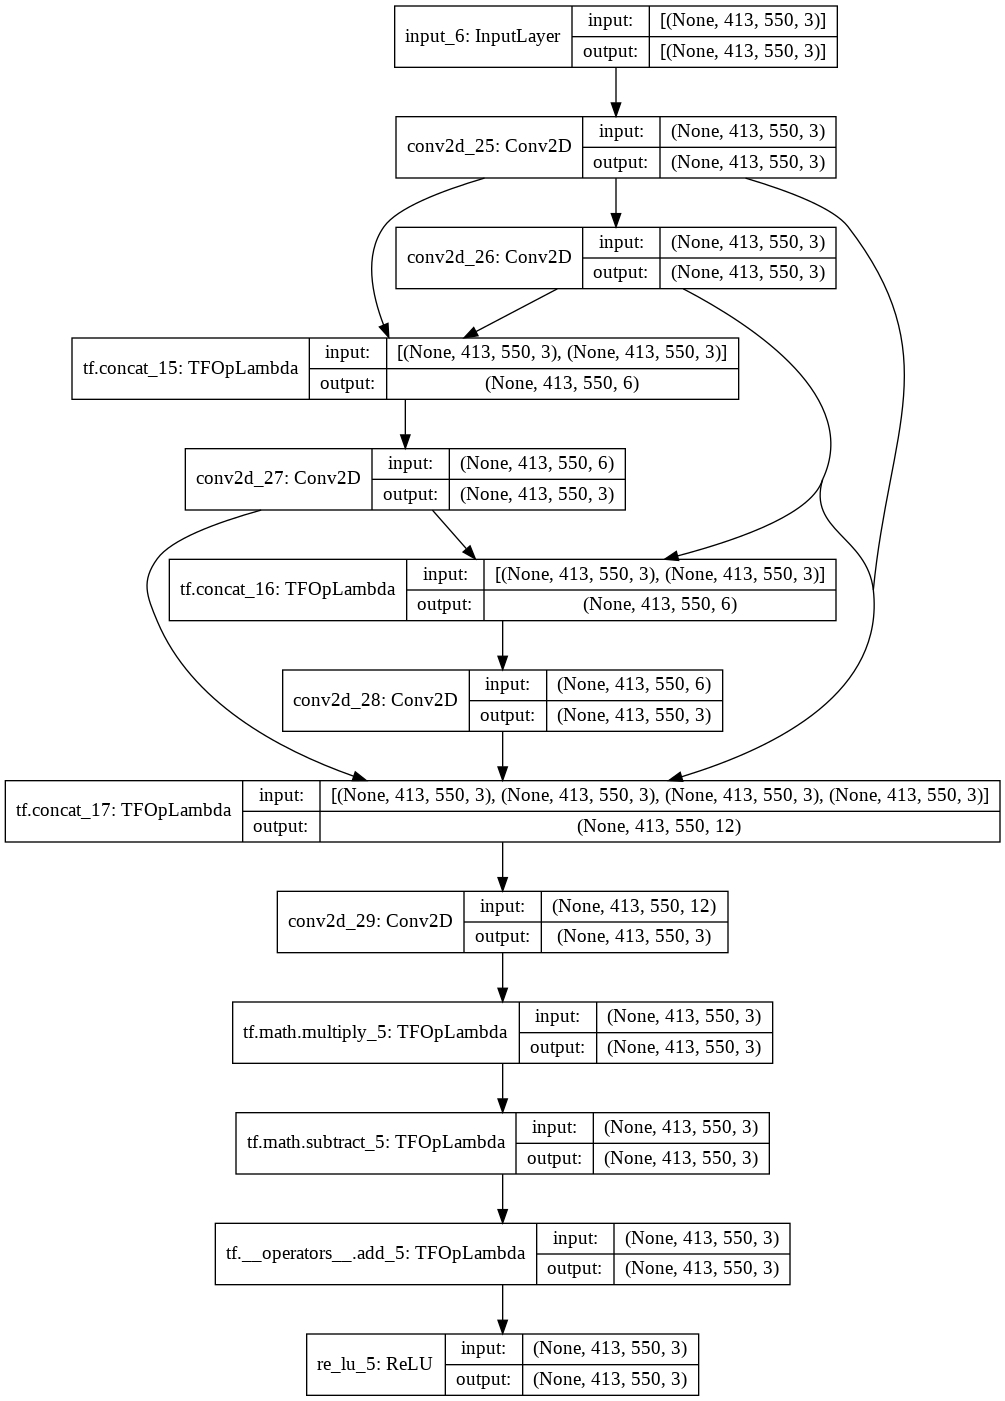

In [50]:
model=dehaze_net()
model.build([413,550,3])
model.summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [51]:
# Hyperparameters
epochs = 30
batch_size = 16
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

#train_data, val_data = data_path(orig_img_path = './drive/MyDrive/reside/archive/clear_images', hazy_img_path = './drive/MyDrive/reside/archive/haze')
train_data, val_data = data_path(orig_img_path = '/content/drive/MyDrive/dataset/clear_images', hazy_img_path = '/content/drive/MyDrive/dataset/haze')
#train_data, val_data = data_path()
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 1e-4)
net =dehaze_net()

#net= tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

2976


In [52]:
def custom_loss(orig,pred):
  a=tf.keras.losses.MAE(orig,pred)
  a=tf.math.reduce_mean(a,axis=None)
  b=tf.image.ssim_multiscale(orig,pred,max_val=1)
  b=tf.math.reduce_mean(b,axis=None)
  #print(a.shape)
  #print(b.shape)
  alpha=0.025
  #a=0
  #alpha=1
  return alpha*b+(1-alpha)*a

In [55]:



def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #loss = mean_squared_error(train_batch_orig, train_logits)
                #loss=tf.math.reduce_mean(loss,axis=None)
                #er=tf.keras.losses.MeanAbsoluteError(tf.keras.losses.Reduction.AUTO)
                #loss=er(train_batch_orig, train_logits)/batch_size
                #loss=tf.image.psnr(train_batch_orig, train_logits, max_val=1)
                #loss=tf.image.ssim(train_batch_orig, train_logits, max_val=1, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
                loss=custom_loss(train_batch_orig, train_logits)
                #loss=tf.math.reduce_mean(loss)
                #print(loss)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        net.save('trained_model')           # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()


Start of epoch 0 [===]  -  Training Loss: 0.2444

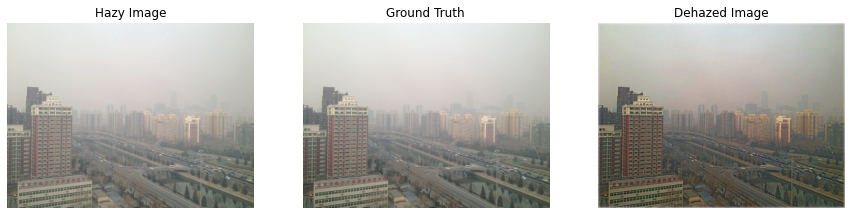

  -  Validation Loss: 0.0150  -   Time taken: 1803.58s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 1 [===]  -  Training Loss: 0.0121

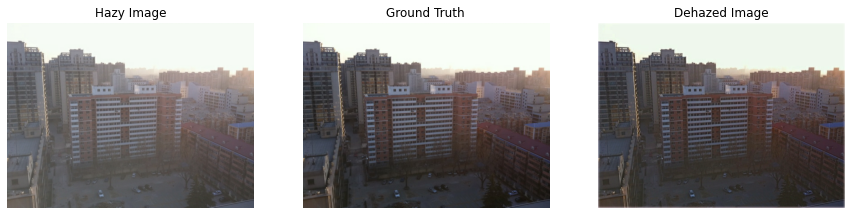

  -  Validation Loss: 0.0114  -   Time taken: 394.83s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 2 [===]  -  Training Loss: 0.0100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


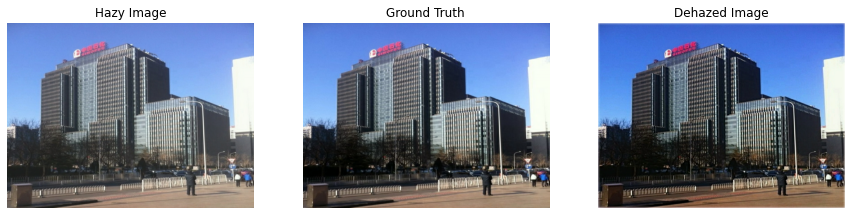

  -  Validation Loss: 0.0103  -   Time taken: 392.32s
INFO:tensorflow:Assets written to: trained_model/assets

Start of epoch 3 [==

In [ ]:
%%time
train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)

In [ ]:
net.trainable_weights

[<tf.Variable 'conv2d_15/kernel:0' shape=(1, 1, 3, 3) dtype=float32, numpy=
 array([[[[-0.01266619,  0.03565572,  0.04239405],
          [ 0.00783089,  0.01615782,  0.03940755],
          [ 0.02224293, -0.02430672, -0.01513277]]]], dtype=float32)>,
 <tf.Variable 'conv2d_15/bias:0' shape=(3,) dtype=float32, numpy=array([0.03430558, 0.03597264, 0.03529609], dtype=float32)>,
 <tf.Variable 'conv2d_16/kernel:0' shape=(3, 3, 3, 3) dtype=float32, numpy=
 array([[[[ 0.02384468,  0.02287831,  0.02878634],
          [ 0.00397418,  0.03510009,  0.03823818],
          [ 0.06126409,  0.01285898, -0.00855933]],
 
         [[ 0.0240409 ,  0.02074694,  0.02498251],
          [ 0.0178854 ,  0.03965921,  0.0265933 ],
          [ 0.02046043,  0.0222129 ,  0.00418419]],
 
         [[ 0.03041109,  0.01054587,  0.01457811],
          [ 0.0143343 ,  0.02347234,  0.02958611],
          [ 0.0054429 , -0.00700141,  0.05659569]]],
 
 
        [[[-0.00588618,  0.02833149,  0.01517381],
          [ 0.00408431,  0.

In [ ]:
w=np.array([[[[-0.02257396, -0.01143149, -0.04359509],
          [-0.00892601,  0.01558365, -0.01650511],
          [-0.01819851,  0.01050926, -0.03258056],
          [ 0.01218766,  0.01308854, -0.02768373],
          [ 0.01775841,  0.03578694, -0.01756023],
          [-0.01155933,  0.006618  , -0.02260049]],
 
         [[ 0.00660475, -0.01203285, -0.01556851],
          [-0.03569239,  0.01743895, -0.0393276 ],
          [-0.00072851,  0.01777775,  0.00012148],
          [-0.01647701,  0.02194119, -0.04869748],
          [-0.04364485,  0.04173912, -0.03830205],
          [ 0.00375027,  0.00746626, -0.01779252]],
 
         [[-0.04968802,  0.0236836 , -0.03163506],
          [-0.01047026,  0.01910006,  0.02585194],
          [ 0.00322623,  0.00835075, -0.01133379],
          [-0.02892186, -0.00443262, -0.0353447 ],
          [-0.03794611,  0.00959804, -0.03445867],
          [-0.04414218,  0.01651249, -0.00062871]],
 
         [[-0.03893567,  0.0321834 , -0.00385944],
          [-0.01018263,  0.00032612, -0.01815434],
          [-0.02332831,  0.04056226,  0.01350898],
          [-0.03466084,  0.04520284, -0.03272   ],
          [-0.063187  ,  0.03089505, -0.00817696],
          [-0.02461625,  0.00658035, -0.02421118]],
 
         [[-0.01761042,  0.01522126, -0.02444245],
          [ 0.0143845 , -0.00656014, -0.02348262],
          [-0.00429705,  0.01388183, -0.07437933],
          [-0.05521101,  0.0128574 , -0.02668766],
          [-0.01292174,  0.00913505, -0.01007185],
          [-0.0272584 ,  0.03935892, -0.01034584]]],
 
 
        [[[-0.03467548,  0.04456703, -0.04938721],
          [-0.03767283,  0.03462343, -0.06341541],
          [-0.0069768 , -0.01409286, -0.01763332],
          [-0.02576756,  0.02863631, -0.02326906],
          [ 0.00099284,  0.02481005, -0.08586887],
          [-0.07063994,  0.04292858, -0.02527565]],
 
         [[-0.01602891,  0.02777181, -0.02735109],
          [-0.01850602,  0.00165966, -0.03650449],
          [-0.00434785,  0.01053715, -0.02138338],
          [-0.01347938,  0.02192072,  0.0010892 ],
          [ 0.00427319, -0.00313713, -0.05071392],
          [-0.03622821,  0.02101725, -0.04652065]],
 
         [[-0.00939845,  0.04619116,  0.0136309 ],
          [-0.02664371, -0.02846216, -0.03512914],
          [-0.03479157,  0.00277462, -0.01640905],
          [-0.02577075,  0.03503647, -0.04328915],
          [-0.03821607,  0.04432683, -0.04907171],
          [-0.03963686,  0.03134667, -0.02830694]],
 
         [[-0.054683  ,  0.0289527 , -0.03214712],
          [-0.03379377,  0.02999317, -0.01931702],
          [-0.05816691, -0.02097847, -0.03866063],
          [-0.0278668 ,  0.02443024, -0.06421813],
          [-0.06098057,  0.00771432, -0.01454274],
          [ 0.01720834,  0.01225677, -0.0479492 ]],
 
         [[ 0.01443429,  0.00867908,  0.00336599],
          [-0.04644747,  0.02976873, -0.00173754],
          [-0.00280979,  0.01042442,  0.00292504],
          [ 0.00885499,  0.03549601, -0.04470795],
          [-0.02225782,  0.01595848, -0.05031059],
          [-0.06564227,  0.02491642, -0.0244716 ]]],
 
 
        [[[ 0.00495017,  0.00414111, -0.00954997],
          [-0.04324474,  0.00158861, -0.03763811],
          [-0.00829528,  0.04515276, -0.00914062],
          [-0.04633186,  0.04648611, -0.0423218 ],
          [-0.03219951,  0.0019619 ,  0.00032579],
          [-0.05255757,  0.05885221, -0.03168527]],
 
         [[-0.02211908,  0.05176067, -0.00860009],
          [-0.06086775, -0.00088216, -0.0314145 ],
          [-0.0227512 ,  0.03719113, -0.00096613],
          [-0.03239836,  0.05519361, -0.0073579 ],
          [-0.03038752, -0.00810558, -0.02071781],
          [-0.03648198,  0.03705461, -0.04462358]],
 
         [[-0.01040063,  0.00108027, -0.00491378],
          [-0.00259413,  0.05267957, -0.0449841 ],
          [-0.01494493,  0.0047143 , -0.01197602],
          [-0.01510028,  0.00542255, -0.06543964],
          [-0.02695754,  0.03664467, -0.01295453],
          [-0.02100781,  0.00842552, -0.00661809]],
 
         [[-0.06731007,  0.02687625, -0.01488377],
          [-0.04696361,  0.0313912 ,  0.00453268],
          [-0.0121754 ,  0.01882321, -0.02407983],
          [-0.03006215,  0.03183494, -0.0208721 ],
          [-0.03521771,  0.00639132, -0.01458376],
          [-0.03914543,  0.02163013, -0.03858922]],
 
         [[-0.01844766,  0.02170234,  0.00567535],
          [ 0.01026612,  0.03472463,  0.00362555],
          [-0.01742128,  0.00118457, -0.01951829],
          [ 0.00249715,  0.05016873, -0.00848181],
          [-0.0055898 ,  0.02125742, -0.03400738],
          [-0.0129798 ,  0.06907918, -0.01767136]]],
 
 
        [[[-0.03850338,  0.02722155, -0.03050566],
          [-0.02404723, -0.0173788 , -0.0266085 ],
          [-0.01659994,  0.00561756, -0.01165092],
          [-0.03574487,  0.00865015, -0.00964987],
          [-0.03726207,  0.01501477, -0.00938899],
          [-0.03343659,  0.00845698, -0.05249429]],
 
         [[-0.03219955,  0.01580804, -0.0057225 ],
          [-0.03381415,  0.03216251, -0.01275317],
          [-0.01250606,  0.06414519, -0.01589757],
          [-0.00840854,  0.03307199, -0.03646569],
          [-0.02215476,  0.04401389, -0.03084939],
          [-0.0513687 ,  0.02435008, -0.06336374]],
 
         [[-0.01550259,  0.03147155, -0.01111048],
          [-0.03047967,  0.01839952,  0.00492833],
          [-0.02593898, -0.0002476 ,  0.01863396],
          [-0.0256984 ,  0.04447879, -0.04490512],
          [-0.02321914,  0.02468527, -0.07013569],
          [-0.01655636,  0.05489943, -0.03143622]],
 
         [[-0.03381593,  0.02831707, -0.01252612],
          [-0.0134507 ,  0.01976126, -0.04356953],
          [-0.03484372,  0.01952472, -0.01536306],
          [-0.00423216,  0.03604981, -0.03733698],
          [-0.04233679,  0.06057017, -0.03247591],
          [-0.06111339,  0.00960181, -0.02237533]],
 
         [[-0.00024497,  0.00168231, -0.01624259],
          [-0.01061581, -0.04763662, -0.02713742],
          [-0.05128095,  0.03498506, -0.0570561 ],
          [-0.01651693,  0.03861725, -0.04383633],
          [-0.02153726,  0.02428278, -0.0475222 ],
          [-0.01895894,  0.07248112, -0.06110973]]],
 
 
        [[[-0.03955824,  0.0236184 , -0.03546601],
          [-0.0362297 ,  0.05896477, -0.02875228],
          [-0.0498497 ,  0.01170982, -0.01878926],
          [-0.00647524,  0.03344166, -0.01794462],
          [-0.01271664,  0.0144653 , -0.04631059],
          [-0.05496004,  0.06759283, -0.03761857]],
 
         [[-0.03288428, -0.00511724, -0.03553902],
          [-0.02974224,  0.03843778, -0.03606625],
          [-0.03317573,  0.03774277, -0.05248206],
          [-0.02018031,  0.08071028,  0.00825973],
          [-0.04953705,  0.03809553, -0.03222851],
          [-0.02943544,  0.07932255, -0.01197327]],
 
         [[-0.02628727,  0.02862382, -0.04238423],
          [ 0.01001424,  0.0170892 , -0.01641382],
          [ 0.01265656,  0.01696717, -0.02194981],
          [-0.02977648,  0.05421756, -0.03328167],
          [-0.00039613,  0.01267874, -0.00555261],
          [-0.01898246,  0.04882628, -0.00582205]],
 
         [[-0.02495805,  0.02380066, -0.00584844],
          [-0.03106447,  0.02975299,  0.01196155],
          [-0.01096144,  0.05726143,  0.0051587 ],
          [-0.03709469,  0.04163761, -0.01509582],
          [ 0.00551816,  0.04510599, -0.00398075],
          [-0.01925295,  0.02367943,  0.00440485]],
 
         [[-0.01661452,  0.04954844, -0.03114297],
          [-0.01938283,  0.03341099, -0.0164471 ],
          [-0.01866071,  0.03767879, -0.01992884],
          [-0.04239697,  0.00562063, -0.04436145],
          [-0.04416844, -0.00492845,  0.00261251],
          [-0.03570582,  0.03790148, -0.00624265]]]])

In [ ]:
w.shape

(5, 5, 6, 3)

In [ ]:
net.save('/content/drive/MyDrive/nets/dehazenet')
#model=net
#model.build([512,512,3])
#model.summary()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/nets/dehazenet/assets


In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/Final_compare/HAZY/*.jpg')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_jpeg(img, channels = 3)
        
        img = tf.image.resize(img, size = (413,550), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        directory = '/content/drive/MyDrive/Final_compare/dehazenet'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.jpg'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, im)

        os.chdir('/content')
        i+=1;
        

In [ ]:

new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet',compile=False)
#new_model = tf.keras.models.load_model('/content/drive/MyDrive/nets/dehazenet/trained_model',compile=False)

evaluate_gen(new_model)



0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 

In [ ]:
cp -r trained_model/ /content/drive/MyDrive/nets/dehazenet/trained_model